# ** **PART 1 : UCI HAR data set** **

---




## **Import and unzip data set from drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

base_path = '/content/drive/MyDrive/AI_HW4/UCI HAR Dataset'


Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/AI_HW4/UCI HAR Dataset.zip'
extract_path = '/content/drive/MyDrive/AI_HW4'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("📁 فایل‌ها استخراج شدند")


📁 فایل‌ها استخراج شدند


In [ ]:
!ls "/content/drive/MyDrive/AI_HW4/UCI HAR Dataset/train"


'Inertial Signals'   subject_train.txt	 X_train.txt   y_train.txt


## **Read data after unzip**

In [ ]:
import pandas as pd
import numpy as np
import os

# مسیر پوشه استخراج شده
base_path = '/content/drive/MyDrive/AI_HW4/UCI HAR Dataset'

# خواندن فایل‌ها
X_train = pd.read_csv(os.path.join(base_path, 'train/X_train.txt'), sep='\s+', header=None)
y_train = pd.read_csv(os.path.join(base_path, 'train/y_train.txt'), header=None)

X_test = pd.read_csv(os.path.join(base_path, 'test/X_test.txt'), sep='\s+', header=None)
y_test = pd.read_csv(os.path.join(base_path, 'test/y_test.txt'), header=None)

print("✅ داده‌ها با موفقیت بارگذاری شدند")
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test :", X_test.shape,  "| y_test :", y_test.shape)

✅ داده‌ها با موفقیت بارگذاری شدند
X_train: (7352, 561) | y_train: (7352, 1)
X_test : (2947, 561) | y_test : (2947, 1)


## **pre proccess**

نرمال سازی داده ها با روش Z-score Scaling - StandardScalar

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ نرمال‌سازی انجام شد")

✅ نرمال‌سازی انجام شد


Converting categorical to one-hot encoding

In [ ]:
from tensorflow.keras.utils import to_categorical

# convert to one-hot
y_train_cat = to_categorical(y_train - 1)  # کلاس‌ها 1 تا 6 هستن، باید 0 تا 5 بشن
y_test_cat = to_categorical(y_test - 1)

print("✅ labels converted to one-hot")
print("y_train_cat shape:", y_train_cat.shape)

✅ labels converted to one-hot
y_train_cat shape: (7352, 6)


## **Megre And split train test**

ادغام داده ها و تقسیم مجدد با نسبت تعیین شده ۸۵/۱۵

In [ ]:
from sklearn.model_selection import train_test_split

# ادغام داده‌ها
X_all = np.concatenate((X_train_scaled, X_test_scaled), axis=0)
y_all = np.concatenate((y_train_cat, y_test_cat), axis=0)

print("🔢 کل نمونه‌ها:", X_all.shape[0])

# بازگردانی لیبل اصلی برای stratify
y_all_labels = np.argmax(y_all, axis=1)  # چون y_all به صورت one-hot است

# تقسیم 85٪ آموزش / 15٪ تست
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_all, y_all, test_size=0.15, stratify=y_all_labels, random_state=42
)

print("✅تقسیم‌بندی انجام شد")
print("X_train:", X_train_final.shape, "| y_train:", y_train_final.shape)
print("X_test :", X_test_final.shape,  "| y_test :", y_test_final.shape)


🔢 کل نمونه‌ها: 10299
✅تقسیم‌بندی انجام شد
X_train: (8754, 561) | y_train: (8754, 6)
X_test : (1545, 561) | y_test : (1545, 6)


## **MLP**

شبکه MLP

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# تعریف مدل
mlp_model = Sequential()
mlp_model.add(Dense(128, activation='relu', input_shape=(X_train_final.shape[1],)))
mlp_model.add(Dropout(0.3))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dense(6, activation='softmax'))  #   تعداد 6 کلاس خروجی

# کامپایل مدل
mlp_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

mlp_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               71936     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 80,582
Trainable params: 80,582
Non-trainable params: 0
_________________________________________________________________


## **CNN**

CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten

# reshape ورودی‌ها
X_train_cnn = X_train_final.reshape(-1, 561, 1)
X_test_cnn = X_test_final.reshape(-1, 561, 1)

# تعریف مدل CNN
cnn_model = Sequential()

cnn_model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(561, 1)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))

cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.3))

cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dense(6, activation='softmax'))

# کامپایل مدل
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 557, 32)           192       
                                                                 
 batch_normalization (BatchN  (None, 557, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 278, 32)          0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 278, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 276, 64)           6208      
                                                                 
 batch_normalization_1 (Batc  (None, 276, 64)         

## **Train MLP**

train MLP

In [ ]:
from tensorflow.keras.optimizers import Adam

# تعریف optimizer با نرخ یادگیری دلخواه
optimizer = Adam(learning_rate=0.001)

# کامپایل مجدد مدل با optimizer مشخص
mlp_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# آموزش مدل MLP
mlp_history = mlp_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_test_final, y_test_final),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
274/274 [==============================] - 4s 9ms/step - loss: 0.3173 - accuracy: 0.8693 - val_loss: 0.1066 - val_accuracy: 0.9573
Epoch 2/50
274/274 [==============================] - 3s 12ms/step - loss: 0.1282 - accuracy: 0.9502 - val_loss: 0.0812 - val_accuracy: 0.9676
Epoch 3/50
274/274 [==============================] - 3s 10ms/step - loss: 0.1015 - accuracy: 0.9590 - val_loss: 0.0805 - val_accuracy: 0.9709
Epoch 4/50
274/274 [==============================] - 2s 7ms/step - loss: 0.0826 - accuracy: 0.9690 - val_loss: 0.0701 - val_accuracy: 0.9735
Epoch 5/50
274/274 [==============================] - 2s 7ms/step - loss: 0.0745 - accuracy: 0.9716 - val_loss: 0.0764 - val_accuracy: 0.9702
Epoch 6/50
274/274 [==============================] - 2s 7ms/step - loss: 0.0799 - accuracy: 0.9701 - val_loss: 0.1232 - val_accuracy: 0.9560
Epoch 7/50
274/274 [==============================] - 1s 4ms/step - loss: 0.0679 - accuracy: 0.9751 - val_loss: 0.0597 - val_accuracy: 0.9754
Epoc

## **Train CNN**

In [ ]:
X_train_cnn = X_train_cnn.astype('float32')
X_test_cnn = X_test_cnn.astype('float32')
y_train_final = y_train_final.astype('float32')
y_test_final = y_test_final.astype('float32')


train CNN

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

optimizer = Adam(learning_rate=0.001)

cnn_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_history = cnn_model.fit(
    X_train_cnn, y_train_final,
    validation_data=(X_test_cnn, y_test_final),
    epochs=50,
    batch_size=32,
    verbose=1
)



Epoch 1/50
274/274 [==============================] - 27s 89ms/step - loss: 0.3144 - accuracy: 0.8934 - val_loss: 0.3318 - val_accuracy: 0.8621
Epoch 2/50
274/274 [==============================] - 17s 64ms/step - loss: 0.1186 - accuracy: 0.9546 - val_loss: 0.0830 - val_accuracy: 0.9676
Epoch 3/50
274/274 [==============================] - 20s 72ms/step - loss: 0.0846 - accuracy: 0.9679 - val_loss: 0.0846 - val_accuracy: 0.9657
Epoch 4/50
274/274 [==============================] - 20s 73ms/step - loss: 0.0700 - accuracy: 0.9749 - val_loss: 0.0433 - val_accuracy: 0.9819
Epoch 5/50
274/274 [==============================] - 17s 63ms/step - loss: 0.0668 - accuracy: 0.9742 - val_loss: 0.0539 - val_accuracy: 0.9773
Epoch 6/50
274/274 [==============================] - 17s 63ms/step - loss: 0.0550 - accuracy: 0.9780 - val_loss: 0.0595 - val_accuracy: 0.9767
Epoch 7/50
274/274 [==============================] - 17s 63ms/step - loss: 0.0519 - accuracy: 0.9798 - val_loss: 0.0510 - val_accuracy:

## **MLP plots**


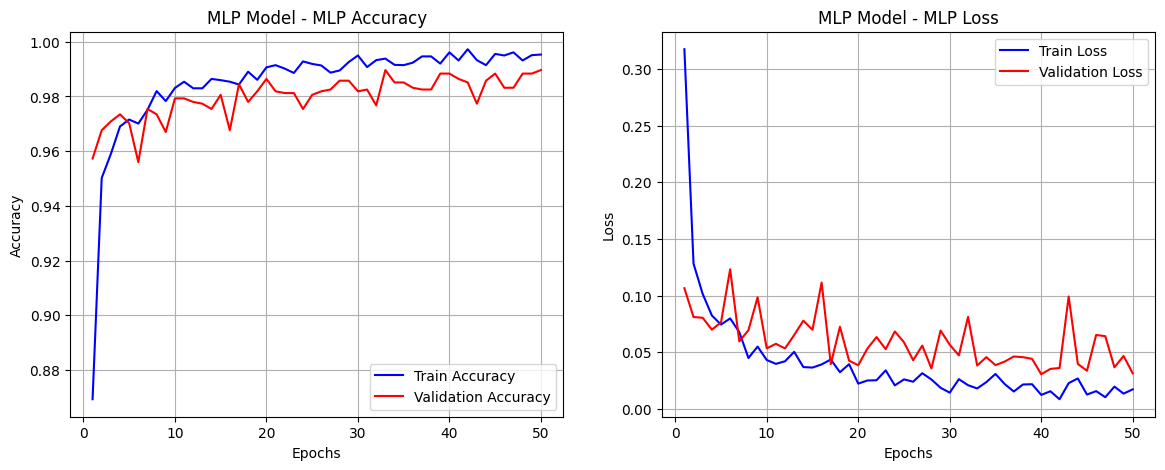

In [ ]:
import matplotlib.pyplot as plt

def plot_history(mlp_history, title='MLP Model'):
    acc = mlp_history.history['accuracy']
    val_acc = mlp_history.history['val_accuracy']
    loss = mlp_history.history['loss']
    val_loss = mlp_history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(14, 5))

    # دقت
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'{title} - MLP Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # خطا
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Train Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'{title} - MLP Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()
plot_history(mlp_history, title='MLP Model')



##**CNN plots**

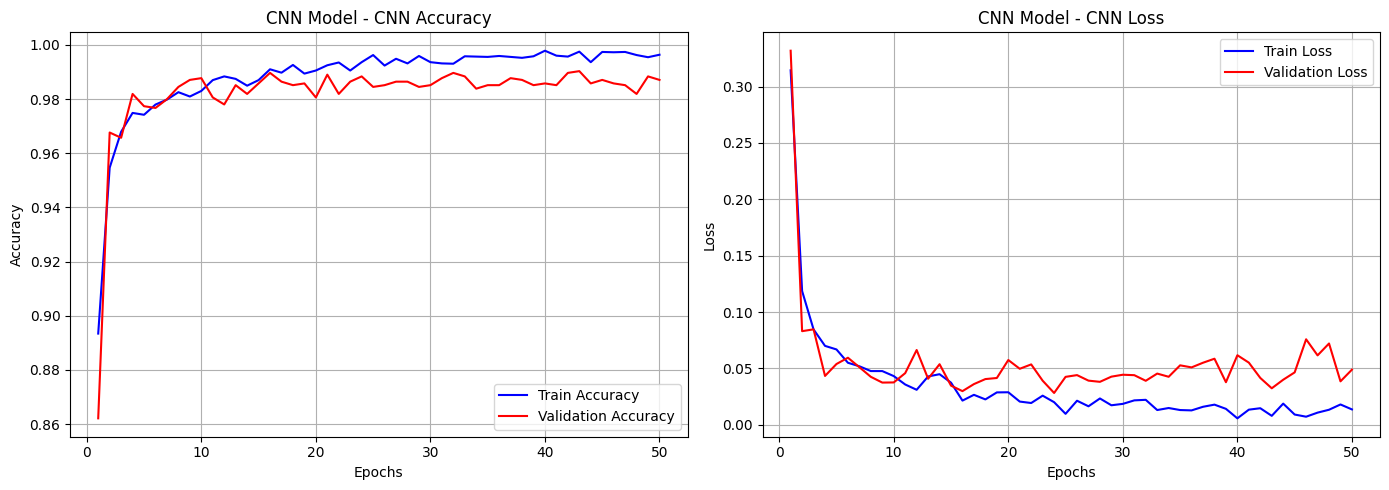

In [ ]:
import matplotlib.pyplot as plt

def plot_history(cnn_history, title='CNN Model'):
    acc = cnn_history.history['accuracy']
    val_acc = cnn_history.history['val_accuracy']
    loss = cnn_history.history['loss']
    val_loss = cnn_history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(14, 5))

    # دقت
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.title(f'{title} - CNN Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # خطا
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Train Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title(f'{title} - CNN Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# فراخوانی تابع
plot_history(cnn_history, title='CNN Model')


## **MLP & CNN Accuracy**

In [ ]:
# دقت نهایی مدل MLP
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test_final, y_test_final, verbose=0)
print(f"📊 MLP - Test Accuracy: {mlp_accuracy:.4f} | Test Loss: {mlp_loss:.4f}")

# دقت نهایی مدل CNN
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test_final, verbose=0)
print(f"📊 CNN - Test Accuracy: {cnn_accuracy:.4f} | Test Loss: {cnn_loss:.4f}")


📊 MLP - Test Accuracy: 0.9896 | Test Loss: 0.0315
📊 CNN - Test Accuracy: 0.9871 | Test Loss: 0.0489


## **MLP Confusion Matrix**

49/49 [==============================] - 0s 2ms/step


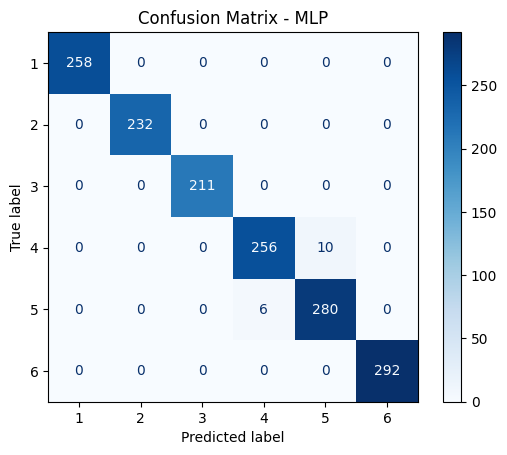

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# پیش‌بینی با مدل MLP
y_pred_mlp = mlp_model.predict(X_test_final)
y_pred_mlp_labels = y_pred_mlp.argmax(axis=1)
y_true_labels = y_test_final.argmax(axis=1)

# رسم ماتریس آشفتگی
cm_mlp = confusion_matrix(y_true_labels, y_pred_mlp_labels)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=[1, 2, 3, 4, 5, 6])
disp_mlp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - MLP")
plt.show()


## **CNN Confusion Matrix**

49/49 [==============================] - 1s 19ms/step


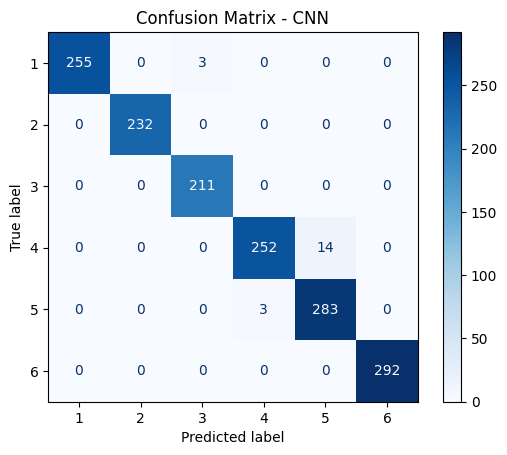

In [ ]:
# پیش‌بینی با مدل CNN
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn_labels = y_pred_cnn.argmax(axis=1)

# رسم ماتریس آشفتگی
cm_cnn = confusion_matrix(y_true_labels, y_pred_cnn_labels)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=[1, 2, 3, 4, 5, 6])
disp_cnn.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - CNN")
plt.show()


# ** **PART 2 : NEU Surface Defects** **

---



## **unzip file & define paths**

In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/AI_HW4/NEU-DET Dataset.zip"
extract_path = "/content/drive/MyDrive/AI_HW4"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ فایل NEU-DET استخراج شد.")


In [ ]:
train_dir = "/content/drive/MyDrive/AI_HW4/NEU-DET/train/images"
val_dir   = "/content/drive/MyDrive/AI_HW4/NEU-DET/validation/images"

## **load images from folders & load data & Normalize**

In [ ]:
import os
import cv2
import numpy as np

def load_images_from_folder(folder_path, image_size=(224, 224)):
    X = []
    y = []
    class_names = os.listdir(folder_path)

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(class_name)

    return np.array(X), np.array(y)


In [ ]:
X_train, y_train = load_images_from_folder(train_dir)
X_val, y_val     = load_images_from_folder(val_dir)

print("✅ شکل داده‌ها:")
print("X_train:", X_train.shape, " | y_train:", y_train.shape)
print("X_val:", X_val.shape, "   | y_val:", y_val.shape)


✅ شکل داده‌ها:
X_train: (1440, 224, 224, 3)  | y_train: (1440,)
X_val: (360, 224, 224, 3)    | y_val: (360,)


In [ ]:
# نرمال‌سازی پیکسل‌ها
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

## **Merge data - Train Test split 85/15 & one-hot Encoding**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# ادغام X و y (تصاویر و لیبل‌ها)
X_all = np.concatenate([X_train, X_val], axis=0)
y_all = np.concatenate([y_train, y_val], axis=0)

# تبدیل لیبل‌ها به عددی
label_encoder = LabelEncoder()
y_all_encoded = label_encoder.fit_transform(y_all)

# تقسیم ۸۵٪ آموزش / ۱۵٪ تست با حفظ نسبت کلاس‌ها
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_all, y_all_encoded,
    test_size=0.15,
    random_state=42,
    stratify=y_all_encoded
)

# تبدیل لیبل‌ها به one-hot
y_train_cat = to_categorical(y_train_final)
y_test_cat = to_categorical(y_test_final)

# نمایش ابعاد نهایی
print("✅ داده‌ها با موفقیت تقسیم شدند:")
print("X_train_final:", X_train_final.shape, "| y_train_cat:", y_train_cat.shape)
print("X_test_final :", X_test_final.shape,  "| y_test_cat :", y_test_cat.shape)
print("کلاس‌ها:", label_encoder.classes_)


✅ داده‌ها با موفقیت تقسیم شدند:
X_train_final: (1530, 224, 224, 3) | y_train_cat: (1530, 6)
X_test_final : (270, 224, 224, 3) | y_test_cat : (270, 6)
کلاس‌ها: ['crazing' 'inclusion' 'patches' 'pitted_surface' 'rolled-in_scale'
 'scratches']


## **MLP NEU**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

# تعریف مدل MLP
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(224, 224, 3)))
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dense(6, activation='softmax'))  # چون ۶ کلاس داریم

# کامپایل مدل
mlp_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# نمایش خلاصه معماری
mlp_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,569,094 (147.13 MB)

 Trainable params: 38,569,094 (147.13 MB)

 Non-trainable params: 0 (0.00 B)

## **CNN NEU**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

cnn_model = Sequential()

# Block 1
cnn_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.3))

# Block 2
cnn_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.3))

# Block 3
cnn_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.35))

# Block 4
cnn_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.35))


cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(6, activation='softmax'))

# Compile
cnn_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,813,766 (25.99 MB)

 Trainable params: 6,812,806 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

## **TRAIN MLP**

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

mlp_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

mlp_history = mlp_model.fit(
    X_train_final, y_train_cat,
    validation_data=(X_test_final, y_test_cat),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.2265 - loss: 1.6591 - val_accuracy: 0.1963 - val_loss: 1.7486
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.1998 - loss: 1.7061 - val_accuracy: 0.1963 - val_loss: 1.7427
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1958 - loss: 1.7081 - val_accuracy: 0.2741 - val_loss: 1.6879
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2267 - loss: 1.6673 - val_accuracy: 0.2074 - val_loss: 1.7374
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2228 - loss: 1.7102 - val_accuracy: 0.2407 - val_loss: 1.6679
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2592 - loss: 1.6275 - val_accuracy: 0.2852 - val_loss: 1.6268
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2547 - loss: 1.6314 - val_accuracy: 0.2481 - val_loss: 1.6534
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2378 - loss: 1.6568 - val_accuracy: 0.2074 - v

## **TRAIN CNN**

In [ ]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# آموزش
cnn_history = cnn_model.fit(
    X_train_final, y_train_cat,
    validation_data=(X_test_final, y_test_cat),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 244ms/step - accuracy: 0.4149 - loss: 10.7594 - val_accuracy: 0.1667 - val_loss: 33.1093
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.4231 - loss: 1.3816 - val_accuracy: 0.1667 - val_loss: 48.1963
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.5574 - loss: 1.1037 - val_accuracy: 0.1667 - val_loss: 64.3943
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6266 - loss: 0.8836 - val_accuracy: 0.1519 - val_loss: 47.6009
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.6139 - loss: 0.9347 - val_accuracy: 0.1630 - val_loss: 53.9171
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.6710 - loss: 0.8497 - val_accuracy: 0.2259 - val_loss: 57.5871
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6029 - loss: 0.9272 - val_accuracy: 0.1778 - val_loss: 68.6968
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.6474 - loss: 0.8215 - val_accuracy: 

## **MLP NEU - PLOTS**

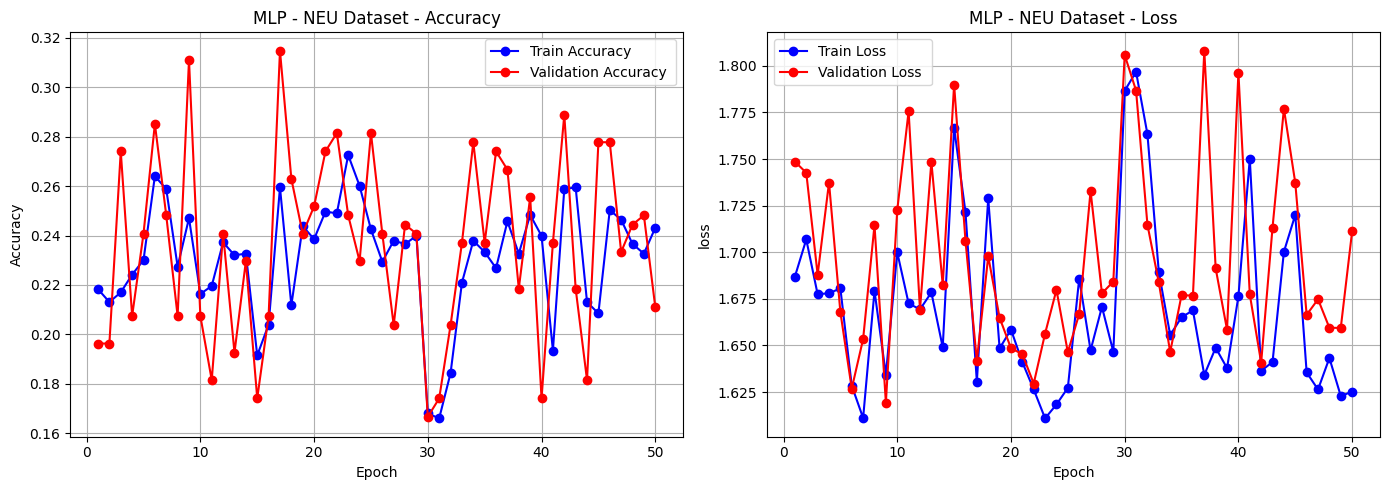

In [ ]:
import matplotlib.pyplot as plt

def plot_mlp_history(mlp_history, title='MLP Model'):
    acc = mlp_history.history['accuracy']
    val_acc = mlp_history.history['val_accuracy']
    loss = mlp_history.history['loss']
    val_loss = mlp_history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # نمودار دقت
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy ')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # نمودار خطا
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Train Loss ')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss ')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# اجرای تابع
plot_mlp_history(mlp_history, title='MLP - NEU Dataset')


## **CNN NEU - PLOTS**

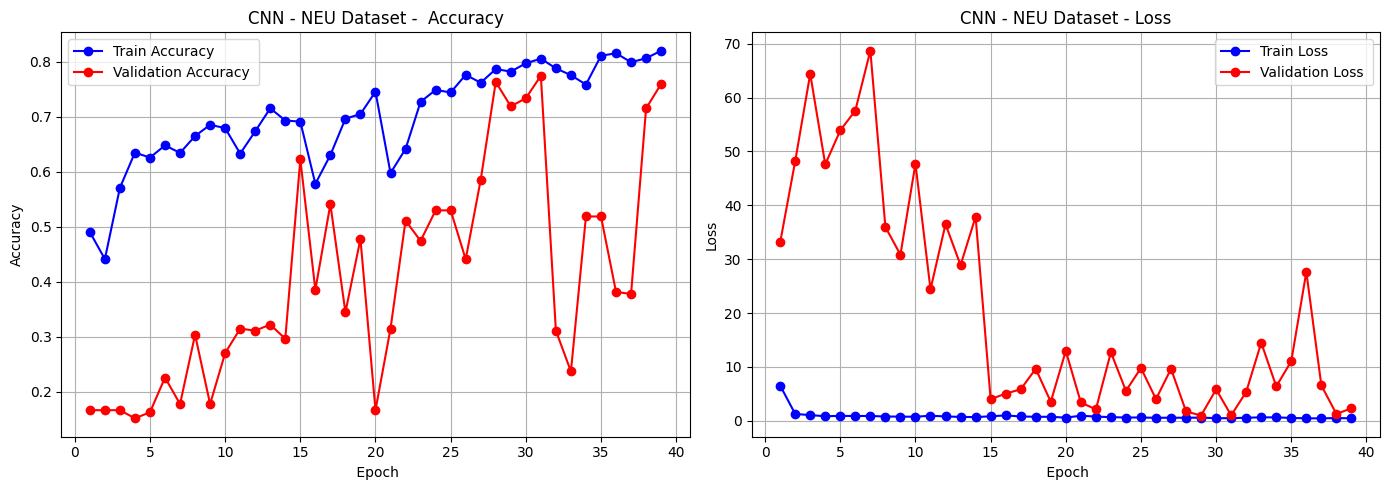

In [ ]:
import matplotlib.pyplot as plt

def plot_cnn_history(cnn_history, title='CNN Model'):
    acc = cnn_history.history['accuracy']
    val_acc = cnn_history.history['val_accuracy']
    loss = cnn_history.history['loss']
    val_loss = cnn_history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # نمودار دقت
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Train Accuracy ')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy ')
    plt.title(f'{title} -  Accuracy')
    plt.xlabel(' Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # نمودار خطا
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Train Loss ')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss ')
    plt.title(f'{title} - Loss')
    plt.xlabel(' Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# اجرای تابع
plot_cnn_history(cnn_history, title='CNN - NEU Dataset')


## **MLP-NEU Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


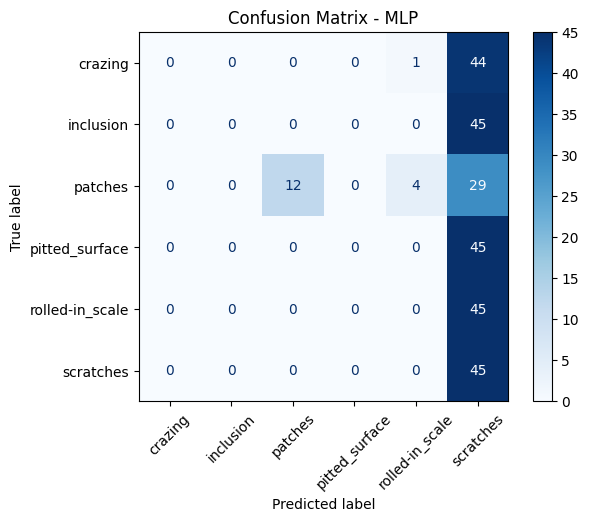

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# پیش‌بینی روی داده‌های آزمون
y_pred_mlp = mlp_model.predict(X_test_final)
y_pred_mlp_labels = np.argmax(y_pred_mlp, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

# نام کلاس‌ها از label encoder
class_names = list(label_encoder.classes_)

# محاسبه و نمایش Confusion Matrix
cm_mlp = confusion_matrix(y_true_labels, y_pred_mlp_labels)
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=class_names)
disp_mlp.plot(cmap='Blues')
plt.title("Confusion Matrix - MLP")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


## **CNN-NEU Confusion Matrix**

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


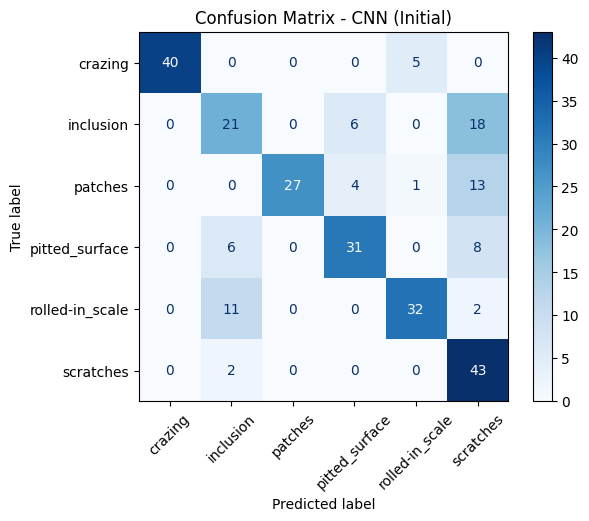

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# پیش‌بینی روی داده‌های آزمون با مدل CNN اولیه
y_pred_cnn = cnn_model.predict(X_test_final)
y_pred_cnn_labels = np.argmax(y_pred_cnn, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

# نام کلاس‌ها از label encoder
class_names = list(label_encoder.classes_)

# محاسبه و نمایش Confusion Matrix
cm_cnn = confusion_matrix(y_true_labels, y_pred_cnn_labels)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=class_names)
disp_cnn.plot(cmap='Blues')
plt.title("Confusion Matrix - CNN (Initial)")
plt.xticks(rotation=45)
plt.grid(False)
plt.show()


## **MLP & CNN NEU FINAL ACCURACY**

In [ ]:
loss_mlp, acc_mlp = mlp_model.evaluate(X_test_final, y_test_cat, verbose=1)
print(f"📊 MLP FINAL ACCURACY FOR TEST DATA: {acc_mlp:.4f}")

loss_cnn, acc_cnn = cnn_model.evaluate(X_test_final, y_test_cat, verbose=1)
print(f"📊 CNN FINAL ACCURACY FOR TEST DATA: {acc_cnn:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2391 - loss: 1.7091
📊 MLP FINAL ACCURACY FOR TEST DATA: 0.2111
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7491 - loss: 0.9572
📊 CNN FINAL ACCURACY FOR TEST DATA: 0.7185


## **CNN - Block dropout**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, SpatialDropout2D, Dropout
from tensorflow.keras.optimizers import Adam

cnn_block_model = Sequential()

cnn_block_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
cnn_block_model.add(BatchNormalization())
cnn_block_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_block_model.add(SpatialDropout2D(0.3))

cnn_block_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_block_model.add(BatchNormalization())
cnn_block_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_block_model.add(SpatialDropout2D(0.3))

cnn_block_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
cnn_block_model.add(BatchNormalization())
cnn_block_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_block_model.add(SpatialDropout2D(0.35))

cnn_block_model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
cnn_block_model.add(BatchNormalization())
cnn_block_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_block_model.add(SpatialDropout2D(0.35))

cnn_block_model.add(Flatten())
cnn_block_model.add(Dense(128, activation='relu'))
cnn_block_model.add(Dropout(0.4))  # اینجا Dropout عادی استفاده می‌کنیم
cnn_block_model.add(Dense(6, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
cnn_block_model.compile(optimizer=optimizer,
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

cnn_block_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_17 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 112, 112, 32)   │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 56, 56, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 28, 28, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 14, 14, 256)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,813,766 (25.99 MB)

 Trainable params: 6,812,806 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn_block_history = cnn_block_model.fit(
    X_train_final, y_train_cat,
    validation_data=(X_test_final, y_test_cat),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.3743 - loss: 8.9594 - val_accuracy: 0.1667 - val_loss: 19.5797
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.4229 - loss: 1.7259 - val_accuracy: 0.1667 - val_loss: 23.2624
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.3973 - loss: 1.3795 - val_accuracy: 0.1667 - val_loss: 36.3600
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4836 - loss: 1.2520 - val_accuracy: 0.1667 - val_loss: 34.2697
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4871 - loss: 1.2705 - val_accuracy: 0.1667 - val_loss: 33.1075
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5166 - loss: 1.1946 - val_accuracy: 0.2222 - val_loss: 29.1027
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.5210 - loss: 1.2023 - val_accuracy: 0.1667 - val_loss: 41.0603
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.5606 - loss: 1.1134 - val_accuracy: 0

In [ ]:
loss_block, acc_block = cnn_block_model.evaluate(X_test_final, y_test_cat, verbose=1)
print(f"📊 دقت نهایی مدل CNN با Block Dropout: {acc_block:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8832 - loss: 0.2842
📊 دقت نهایی مدل CNN با Block Dropout: 0.8741


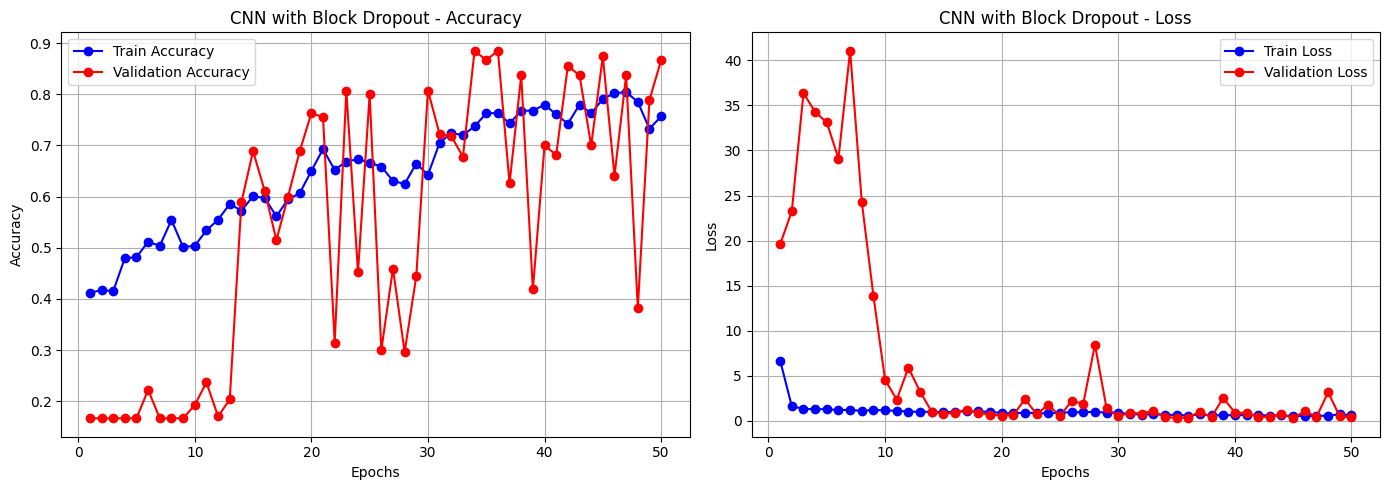

In [ ]:
import matplotlib.pyplot as plt

def plot_cnn_block_history(history, title='CNN with Block Dropout'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # دقت
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # خطا
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Train Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# استفاده:
plot_cnn_block_history(cnn_block_history)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


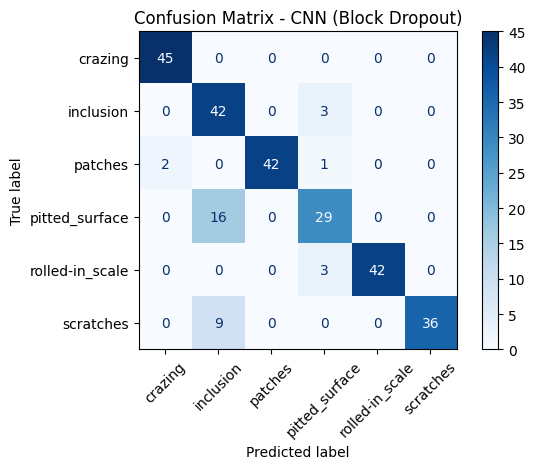

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# پیش‌بینی روی داده‌های آزمون با مدل CNN Block Dropout
y_pred_block = cnn_block_model.predict(X_test_final)
y_pred_block_labels = np.argmax(y_pred_block, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

# نام کلاس‌ها از label encoder
class_names = list(label_encoder.classes_)


# محاسبه و نمایش Confusion Matrix
cm_block = confusion_matrix(y_true_labels, y_pred_block_labels)
disp_block = ConfusionMatrixDisplay(confusion_matrix=cm_block, display_labels=class_names)
disp_block.plot(cmap='Blues')
plt.title("Confusion Matrix - CNN (Block Dropout)")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()


## **CNN-Kernel factorization**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

cnn_fact_model = Sequential()

# Block 1
cnn_fact_model.add(Conv2D(32, (1, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
cnn_fact_model.add(Conv2D(32, (3, 1), activation='relu', padding='same'))
cnn_fact_model.add(BatchNormalization())
cnn_fact_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_fact_model.add(Dropout(0.3))

# Block 2
cnn_fact_model.add(Conv2D(64, (1, 3), activation='relu', padding='same'))
cnn_fact_model.add(Conv2D(64, (3, 1), activation='relu', padding='same'))
cnn_fact_model.add(BatchNormalization())
cnn_fact_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_fact_model.add(Dropout(0.3))

# Block 3
cnn_fact_model.add(Conv2D(128, (1, 3), activation='relu', padding='same'))
cnn_fact_model.add(Conv2D(128, (3, 1), activation='relu', padding='same'))
cnn_fact_model.add(BatchNormalization())
cnn_fact_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_fact_model.add(Dropout(0.35))

# Block 4
cnn_fact_model.add(Conv2D(256, (1, 3), activation='relu', padding='same'))
cnn_fact_model.add(Conv2D(256, (3, 1), activation='relu', padding='same'))
cnn_fact_model.add(BatchNormalization())
cnn_fact_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_fact_model.add(Dropout(0.35))

# FC
cnn_fact_model.add(Flatten())
cnn_fact_model.add(Dense(128, activation='relu'))
cnn_fact_model.add(Dropout(0.4))
cnn_fact_model.add(Dense(6, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
cnn_fact_model.compile(optimizer=optimizer,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

cnn_fact_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 224, 224, 32)   │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 112, 112, 64)   │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 112, 112, 64)   │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 56, 56, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 56, 56, 128)    │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 256)    │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 28, 28, 256)    │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 128)            │             

 Total params: 6,816,742 (26.00 MB)

 Trainable params: 6,815,782 (26.00 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

cnn_fact_history = cnn_fact_model.fit(
    X_train_final, y_train_cat,
    validation_data=(X_test_final, y_test_cat),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.4436 - loss: 1.4480 - val_accuracy: 0.2704 - val_loss: 23.3057
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.4839 - loss: 1.3514 - val_accuracy: 0.2741 - val_loss: 18.9204
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.5502 - loss: 1.1360 - val_accuracy: 0.2185 - val_loss: 19.0737
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.5802 - loss: 1.2116 - val_accuracy: 0.1630 - val_loss: 28.2168
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.6127 - loss: 0.9809 - val_accuracy: 0.2370 - val_loss: 45.8650
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.6800 - loss: 0.8738 - val_accuracy: 0.1778 - val_loss: 36.7816
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.6869 - loss: 0.8300 - val_accuracy: 0.1630 - val_loss: 12.8681
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.6895 - loss: 0.8115 - val_acc

In [ ]:
loss_fact, acc_fact = cnn_fact_model.evaluate(X_test_final, y_test_cat, verbose=1)
print(f"📊 دقت نهایی مدل CNN با Kernel Factorization: {acc_fact:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8588 - loss: 0.4873
📊 دقت نهایی مدل CNN با Kernel Factorization: 0.8667


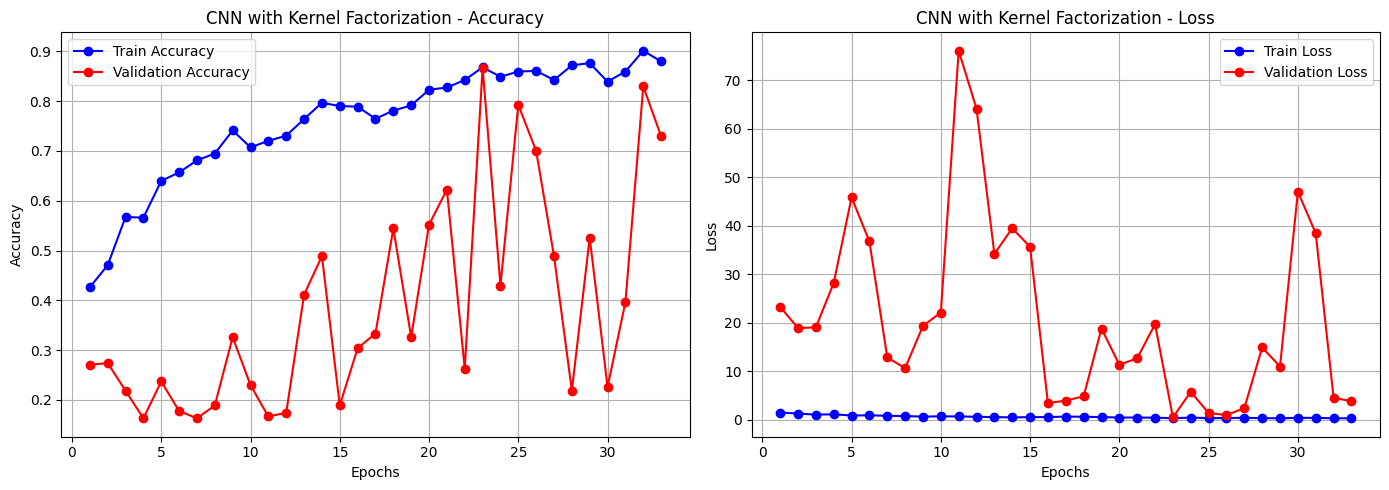

In [ ]:
import matplotlib.pyplot as plt

def plot_cnn_fact_history(history, title='CNN with Kernel Factorization'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # دقت
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # خطا
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Train Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_cnn_fact_history(cnn_fact_history)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step


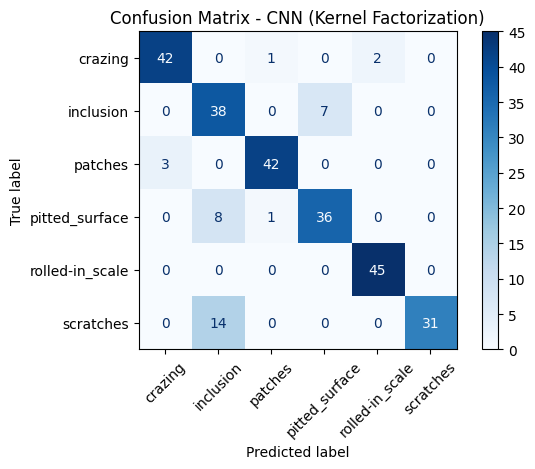

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# پیش‌بینی روی داده‌های آزمون
y_pred_fact = cnn_fact_model.predict(X_test_final)
y_pred_fact_labels = np.argmax(y_pred_fact, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

# نام کلاس‌ها
class_names = list(label_encoder.classes_)


# محاسبه و رسم
cm_fact = confusion_matrix(y_true_labels, y_pred_fact_labels)
disp_fact = ConfusionMatrixDisplay(confusion_matrix=cm_fact, display_labels=class_names)
disp_fact.plot(cmap='Blues')
plt.title("Confusion Matrix - CNN (Kernel Factorization)")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()


# ** **PART 3 : Transfer Learning** **

---


## **Prepare Data**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

train_dir = "/content/drive/MyDrive/AI_HW4/NEU-DET/train/images"
val_dir = "/content/drive/MyDrive/AI_HW4/NEU-DET/validation/images"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)


class_names = list(train_generator.class_indices.keys())
print("کلاس‌ها:", class_names)



Found 1440 images belonging to 6 classes.
Found 360 images belonging to 6 classes.
کلاس‌ها: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# استخراج لیبل‌ها
y_train_labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_dict)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0), 3: np.float64(1.0), 4: np.float64(1.0), 5: np.float64(1.0)}


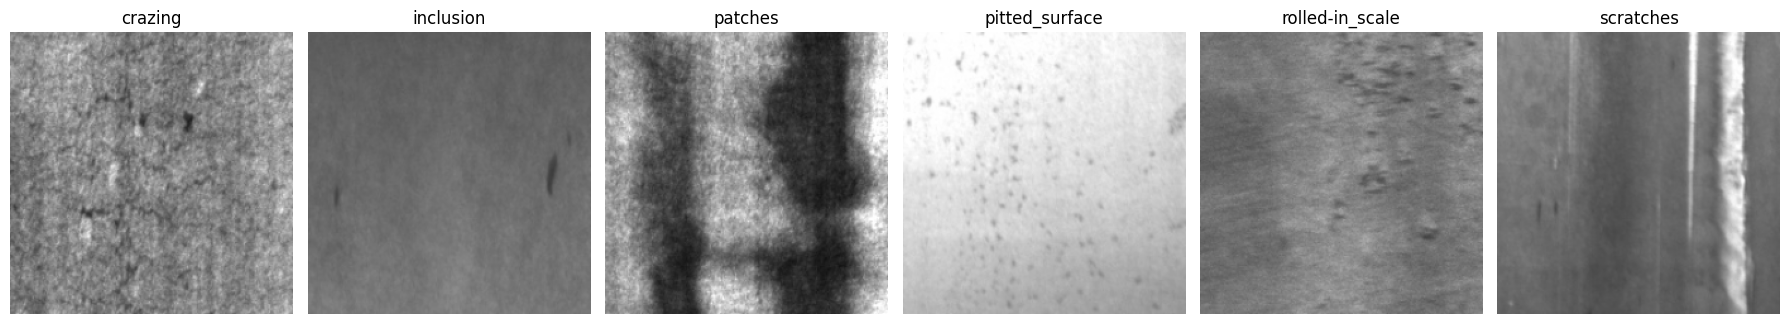

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 6, figsize=(18, 4))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))

    axes[i].imshow(img)
    axes[i].set_title(class_name)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## **Prepare model**

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

# اضافه کردن head با Dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)

model_resnet = Model(inputs=base_model.input, outputs=predictions)

model_resnet.compile(optimizer=Adam(learning_rate=0.001),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


model_resnet.summary()



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,758 (90.98 MB)

 Trainable params: 263,046 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## **ResNet train**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_head = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 479s 10s/step - accuracy: 0.1811 - loss: 1.9424 - val_accuracy: 0.1667 - val_loss: 1.7727
Epoch 2/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 536ms/step - accuracy: 0.1958 - loss: 1.8005 - val_accuracy: 0.1667 - val_loss: 1.7607
Epoch 3/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 533ms/step - accuracy: 0.2263 - loss: 1.7637 - val_accuracy: 0.3222 - val_loss: 1.7471
Epoch 4/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 517ms/step - accuracy: 0.2344 - loss: 1.7592 - val_accuracy: 0.2306 - val_loss: 1.7451
Epoch 5/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 526ms/step - accuracy: 0.2421 - loss: 1.7487 - val_accuracy: 0.1472 - val_loss: 1.7172
Epoch 6/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 515ms/step - accuracy: 0.2603 - loss: 1.7142 - val_accuracy: 0.2611 - val_loss: 1.6917
Epoch 7/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 535ms/step - accuracy: 0.2250 - loss: 1.7097 - val_accuracy: 0.3111 - val_loss: 1.6436
Epoch 8/25
45/45 ━━━━━━━━━━━━━━━━━━━━ 24s 542ms/step - accuracy: 0.2914 - loss: 1.6689 - val_accur

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def fine_tune_resnet(model_resnet, train_generator, val_generator, class_weights_dict,
                     steps=[5, 10, 15], base_lr=1e-5, epochs_per_step=15):

    full_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    for step in steps:
        print(f"\n🔁 Fine-Tuning: Unfreeze last {step} layers")

        for layer in model_resnet.layers:
            layer.trainable = False
        for layer in model_resnet.layers[-step:]:
            layer.trainable = True

        model_resnet.compile(optimizer=Adam(learning_rate=base_lr),
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model_resnet.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs_per_step,
            class_weight=class_weights_dict,
            callbacks=[early_stop],
            verbose=1
        )

        # اضافه کردن هر مرحله به تاریخچه نهایی
        for key in full_history:
            full_history[key] += history.history[key]

    print("✅ مرحله Fine-Tuning کامل شد.")
    return full_history

history_finetune = fine_tune_resnet(model_resnet, train_generator, val_generator, class_weights_dict,
                                    steps=[5, 10, 15], base_lr=1e-5, epochs_per_step=15)



🔁 Fine-Tuning: Unfreeze last 5 layers
Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 674ms/step - accuracy: 0.7679 - loss: 0.6554 - val_accuracy: 0.7611 - val_loss: 0.7014
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 532ms/step - accuracy: 0.7741 - loss: 0.6165 - val_accuracy: 0.7361 - val_loss: 0.7254
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 546ms/step - accuracy: 0.7682 - loss: 0.6211 - val_accuracy: 0.7194 - val_loss: 0.7485
Epoch 4/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 25s 546ms/step - accuracy: 0.7931 - loss: 0.5801 - val_accuracy: 0.7139 - val_loss: 0.7660
Epoch 5/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 23s 504ms/step - accuracy: 0.8024 - loss: 0.5894 - val_accuracy: 0.7167 - val_loss: 0.7741
Epoch 6/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 530ms/step - accuracy: 0.8313 - loss: 0.5481 - val_accuracy: 0.7222 - val_loss: 0.7749

🔁 Fine-Tuning: Unfreeze last 10 layers
Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 642ms/step - accuracy: 0.7917 - loss: 0.6087 - val_accuracy: 0.7222 - val_loss: 0.7137
Epoch 2/15
45/45 ━

## **ResNet Final Accuracy**

In [ ]:

def merge_histories(h1, h2):
    merged = {}
    for key in h1.history.keys():
        merged[key] = h1.history[key] + h2[key]
    return merged

# ترکیب
full_history = merge_histories(history_head, history_finetune)


In [ ]:
# ارزیابی دقت نهایی مدل ResNet بعد از Fine-Tuning
loss_resnet, acc_resnet = model_resnet.evaluate(val_generator, verbose=1)
print(f"📊 Final Accuracy of ResNet-50 (Fine-Tuned): {acc_resnet:.4f} | Loss: {loss_resnet:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8767 - loss: 0.3681
📊 Final Accuracy of ResNet-50 (Fine-Tuned): 0.8028 | Loss: 0.5669


## **ResNet Plots**

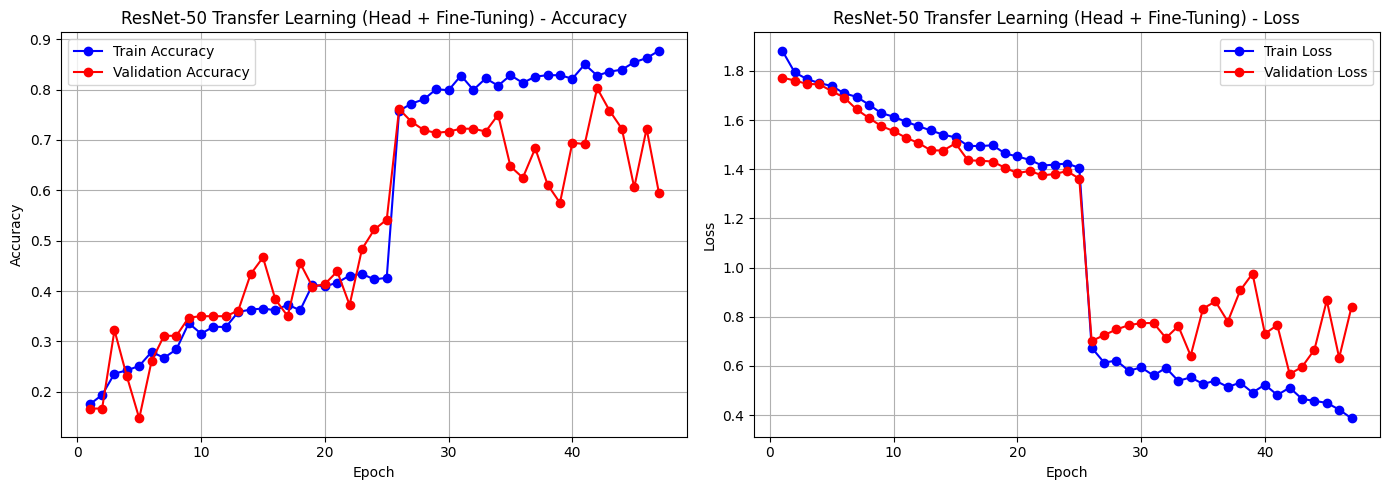

In [ ]:

import matplotlib.pyplot as plt

def plot_history(history_dict, title='ResNet-50 Transfer Learning'):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # دقت
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # خطا
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Train Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# اجرای نمودار
plot_history(full_history, title='ResNet-50 Transfer Learning (Head + Fine-Tuning)')



## **ResNet Confusion Matrix**

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step


<Figure size 800x600 with 0 Axes>

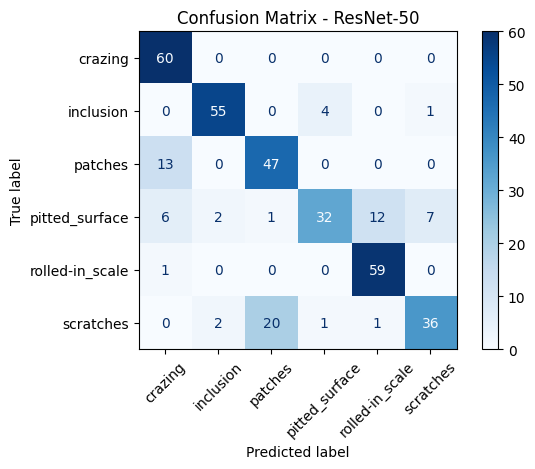

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# پیش‌بینی روی داده‌های اعتبارسنجی (val_generator)
y_pred_probs = model_resnet.predict(val_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# برچسب‌های واقعی
y_true = val_generator.classes

# نام کلاس‌ها (از همان لیستی که قبل ساخته بودی)
class_names = list(val_generator.class_indices.keys())

# محاسبه ماتریس آشفتگی
cm = confusion_matrix(y_true, y_pred)

# رسم
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - ResNet-50")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()
